# Mushroom Classification Dataset EDA

## Introduction

Exploratory Data Analysis (EDA) is a crucial step in any machine learning workflow. For image classification tasks, such as the classification of mushroom images into their respective genera, EDA involves understanding the dataset's characteristics, identifying potential issues, and discovering patterns that can inform model design and training strategy. This process not only helps in ensuring that the data is suitable for the task but also in uncovering insights that could lead to better model performance.

## Data Information

### Importing Libraries

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pathlib import Path
import filecmp
from PIL import Image, ImageFile
import glob

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.model_data import ImageDataset

### Duplicates in the Dataset

After inspecting the directory structure, it was discovered that an inner folder named 'Mushrooms' exists within the 'Mushrooms' directory. To ensure the integrity and consistency of the dataset, it's imperative to verify whether this inner folder duplicates the contents of its parent directory or differs in terms of both content and metadata.

In [2]:
dataset_path = Path("data/Mushrooms")
outer_mushrooms_path = dataset_path
inner_mushrooms_path = Path("data/Mushrooms_inner")

def compare_directories_content(dir1, dir2):
    dircmp = filecmp.dircmp(str(dir1), str(dir2))
    return dircmp.left_list == dircmp.right_list

def compare_directories_metadata(dir1, dir2):
    dir1, dir2 = Path(dir1), Path(dir2)
    
    files_outer = list(dir1.glob('**/*'))
    files_inner = list(dir2.glob('**/*'))

    files_outer = [f for f in files_outer if f.is_file()]
    files_inner = [f for f in files_inner if f.is_file()]

    if len(files_outer) != len(files_inner):
        return False
    
    for file_outer, file_inner in zip(sorted(files_outer), sorted(files_inner)):
        stat_outer = file_outer.stat()
        stat_inner = file_inner.stat()
        if not (stat_outer.st_mode == stat_inner.st_mode and
                stat_outer.st_uid == stat_inner.st_uid and
                stat_outer.st_gid == stat_inner.st_gid):
            return False
    
    return True

same_content = compare_directories_content(outer_mushrooms_path, inner_mushrooms_path)
same_metadata = compare_directories_metadata(outer_mushrooms_path, inner_mushrooms_path)

print("Content Comparison:")
if same_content:
    print("The inner 'Mushrooms' directory has the same content as the outer 'Mushrooms' directory.")
else:
    print("The inner 'Mushrooms' directory does not have the same content as the outer 'Mushrooms' directory.")

print("\nMetadata Comparison:")
if same_metadata:
    print("The inner 'Mushrooms' directory has the same metadata as the outer 'Mushrooms' directory.")
else:
    print("The inner 'Mushrooms' directory does not have the same metadata as the outer 'Mushrooms' directory.")


Content Comparison:
The inner 'Mushrooms' directory has the same content as the outer 'Mushrooms' directory.

Metadata Comparison:
The inner 'Mushrooms' directory has the same metadata as the outer 'Mushrooms' directory.


After conducting a thorough comparison, it has been determined that the inner 'Mushrooms' directory not only replicates the content but also mirrors the metadata attributes of its parent directory. Based on these findings, it is recommended to remove the inner 'Mushrooms' folder to streamline the dataset structure and eliminate redundancy.

### Class Imbalance

In [3]:
class_counts = {}
for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        class_counts[class_dir.name] = sum(1 for _ in class_dir.iterdir() if _.is_file())

df_class_info = pd.DataFrame(list(class_counts.items()), columns=['category_name', 'count'])
print(df_class_info)

  category_name  count
0      Agaricus    353
1       Amanita    750
2       Boletus   1073
3   Cortinarius    836
4      Entoloma    364
5     Hygrocybe    316
6     Lactarius   1563
7       Russula   1148
8       Suillus    311


In [4]:
total_count = df_class_info['count'].sum()

print("Total count:", total_count)

Total count: 6714


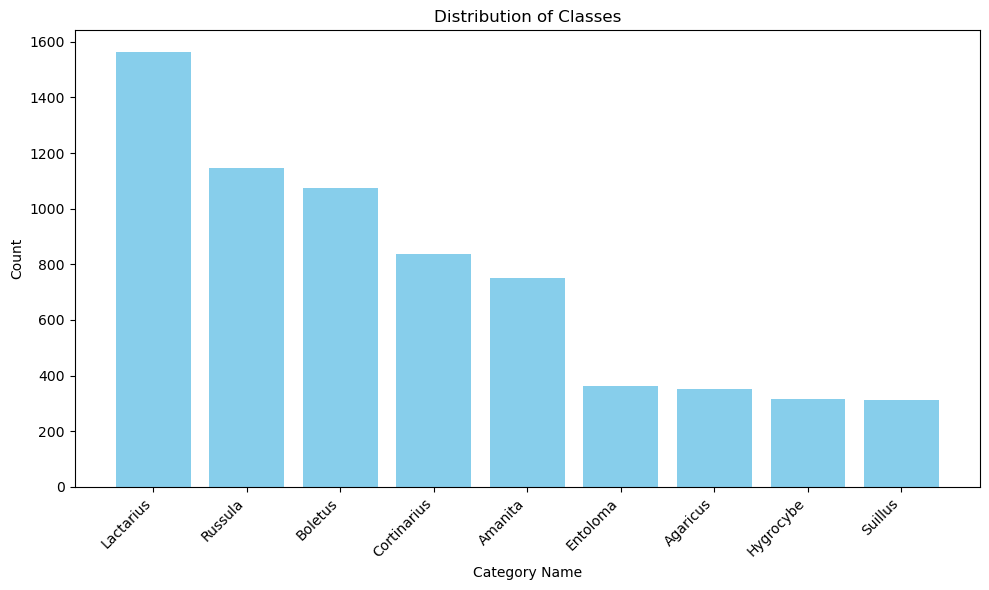

In [5]:
df_class_info_sorted = df_class_info.sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(df_class_info_sorted['category_name'], df_class_info_sorted['count'], color='skyblue')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

While some classes are well-represented with ample data for training a CNN, others are less represented and may require techniques like data augmentation or class weighting to mitigate the class imbalance and improve the CNN's performance on these classes.

### Dimensions of the given Images

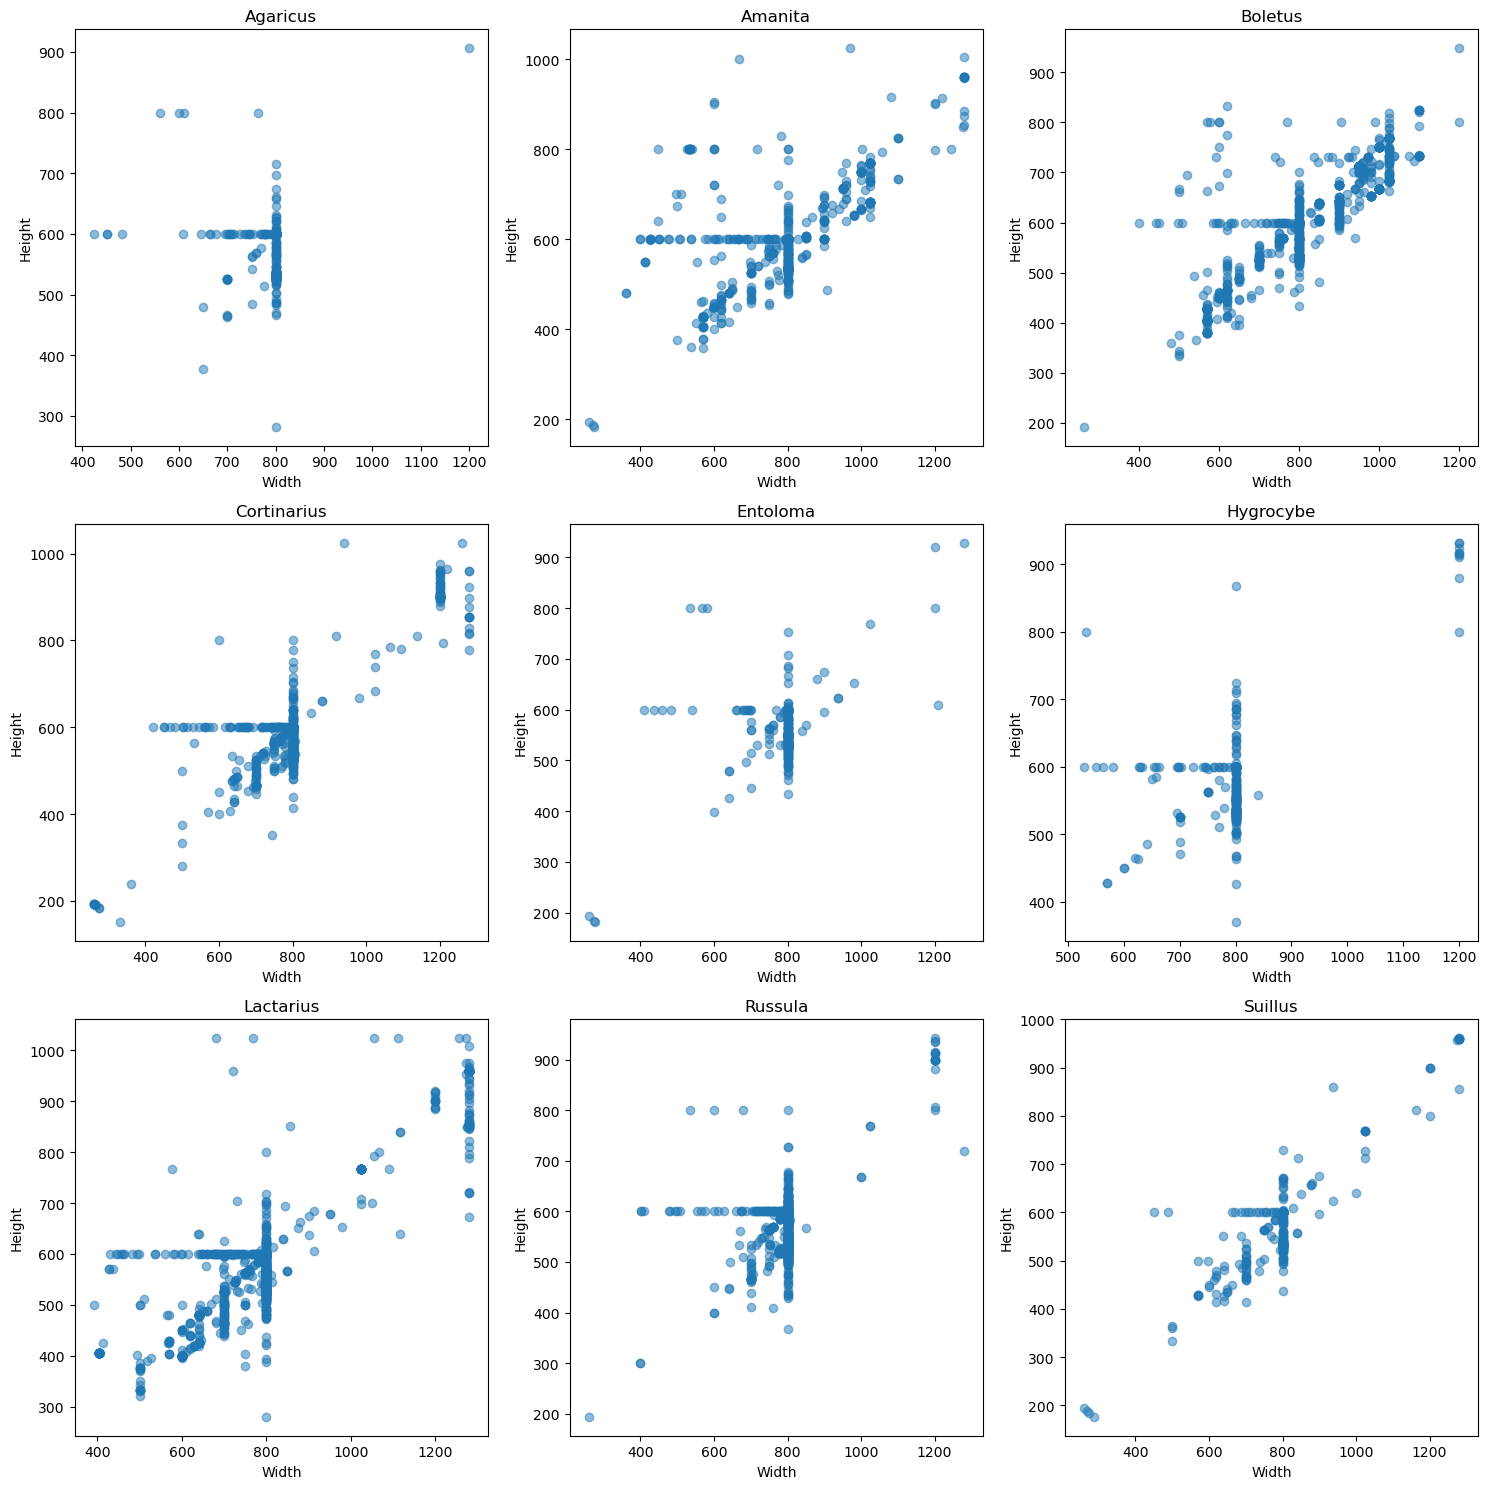

In [6]:
def get_image_dimensions(category_name):
    category_path = dataset_path / category_name
    widths, heights = [], []
    for image_path in category_path.iterdir():
        if image_path.is_file():
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
    return widths, heights
    
for index, row in df_class_info.iterrows():
    category_name = row['category_name']
    widths, heights = get_image_dimensions(category_name)
    df_class_info.at[index, 'img_w_min'] = min(widths)
    df_class_info.at[index, 'img_w_max'] = max(widths)
    df_class_info.at[index, 'img_h_min'] = min(heights)
    df_class_info.at[index, 'img_h_max'] = max(heights)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    category_name = df_class_info.iloc[i]['category_name']
    widths, heights = get_image_dimensions(category_name)
    ax.scatter(widths, heights, alpha=0.5)
    ax.set_title(category_name)
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')

plt.tight_layout()
plt.show()

### Data Samples

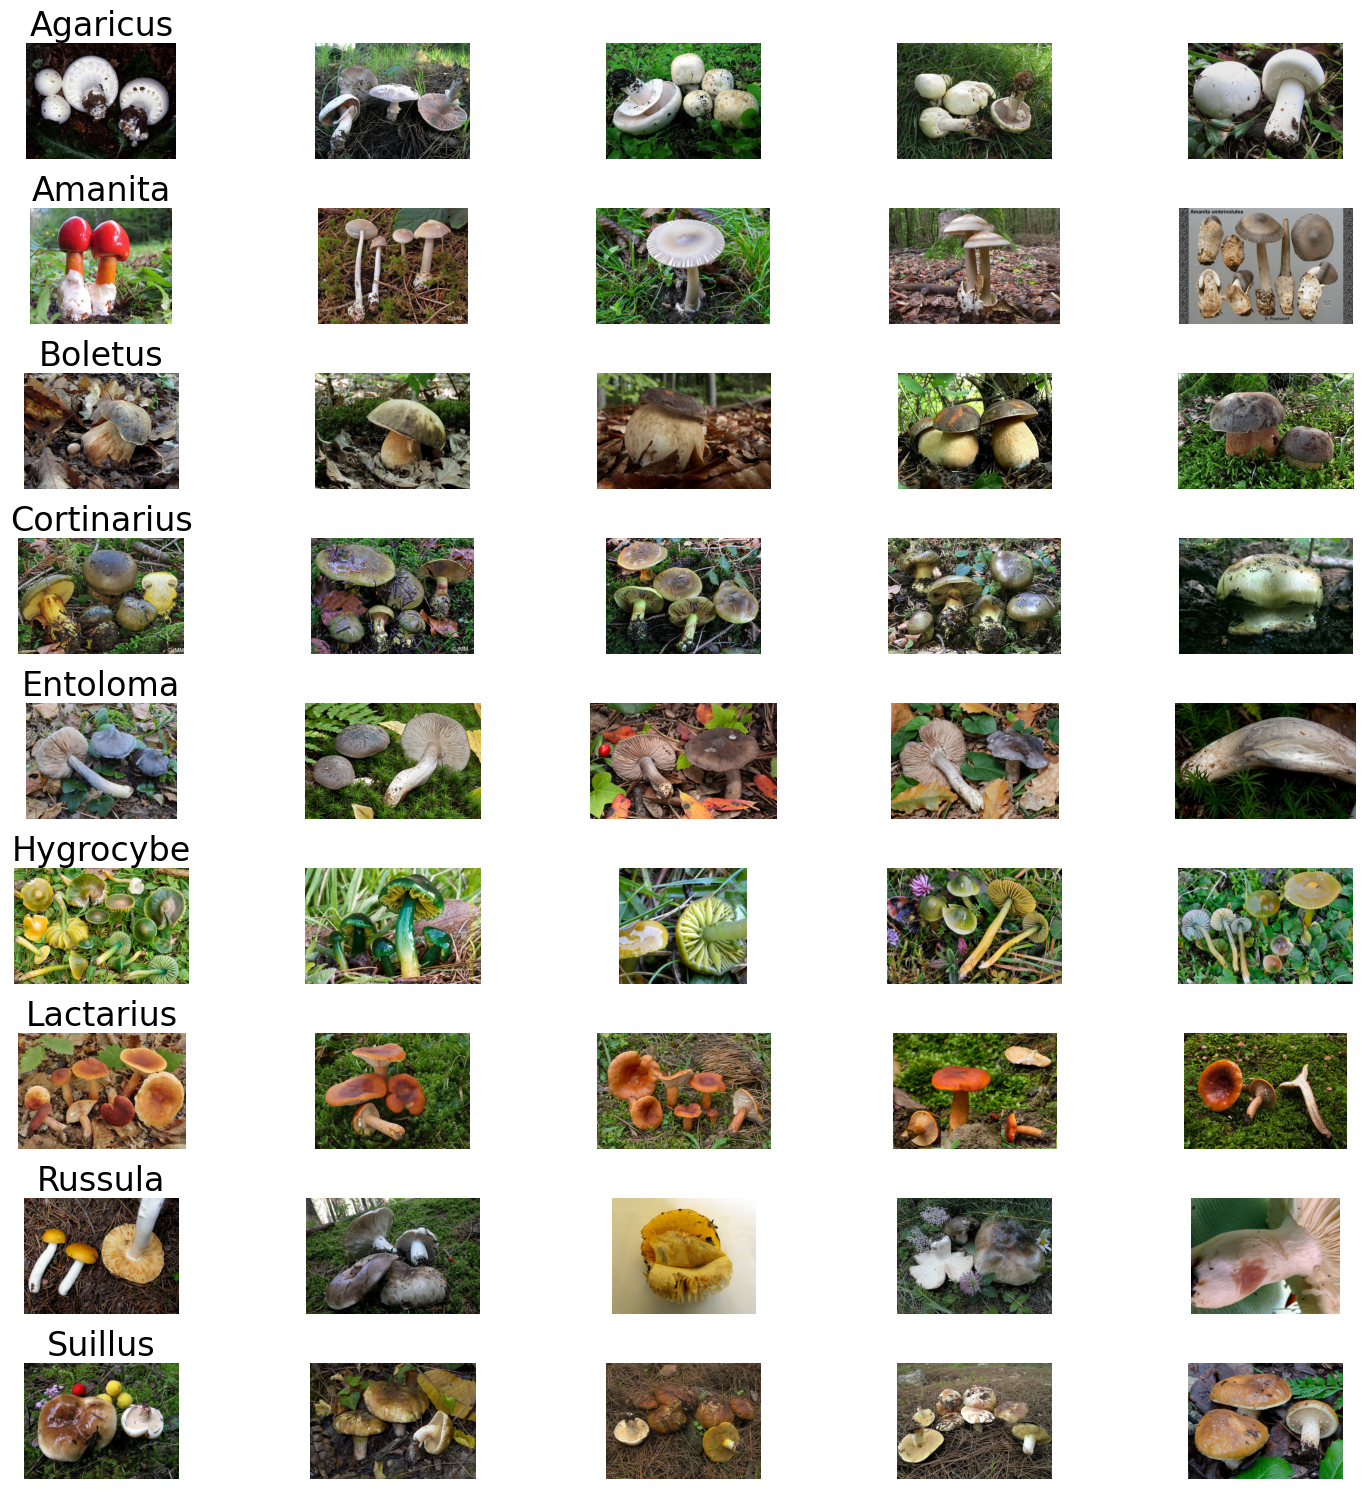

In [7]:
num_images_per_class = 5

def get_image_paths(category_name):
    category_path = dataset_path / category_name
    image_paths = list(category_path.glob('*'))[:num_images_per_class]
    return image_paths

categories = df_class_info['category_name']

num_categories = len(categories)

fig, axes = plt.subplots(num_categories, num_images_per_class, figsize=(15, 15))

for i, category_name in enumerate(categories):
    image_paths = get_image_paths(category_name)
    for j, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        if num_categories > 1:
            ax = axes[i, j]
        else:
            ax = axes[j]
        ax.imshow(img)
        ax.axis('off')
    for j in range(len(image_paths), num_images_per_class):
        if num_categories > 1:
            axes[i, j].axis('off')
        else:
            axes[j].axis('off')
    if num_categories > 1:
        axes[i, 0].set_title(category_name, fontsize=24)
    else:
        axes[0].set_title(category_name, fontsize=24)

plt.tight_layout()
plt.show()

In [8]:
print(df_class_info)

  category_name  count  img_w_min  img_w_max  img_h_min  img_h_max
0      Agaricus    353      423.0     1200.0      282.0      906.0
1       Amanita    750      259.0     1280.0      183.0     1024.0
2       Boletus   1073      262.0     1200.0      192.0      948.0
3   Cortinarius    836      259.0     1280.0      152.0     1024.0
4      Entoloma    364      259.0     1280.0      182.0      928.0
5     Hygrocybe    316      528.0     1200.0      370.0      931.0
6     Lactarius   1563      391.0     1280.0      280.0     1024.0
7       Russula   1148      259.0     1280.0      194.0      942.0
8       Suillus    311      259.0     1280.0      176.0      961.0


### File Formats

In [9]:
def check_file_types(directory_path):
    file_types = set()
    
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            _, extension = os.path.splitext(file)
            file_types.add(extension.lower())
    
    return file_types

directory_path = "data/Mushrooms"
file_types = check_file_types(directory_path)

print("File types found in the directory and its subdirectories:")
for file_type in file_types:
    print(file_type)

File types found in the directory and its subdirectories:
.jpg


### Checking Data for Anomalies

In [11]:
def is_mostly_white_or_black(image_path, black_threshold=(0, 20), white_threshold=(235, 255)):
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        avg_intensity = np.mean(img_array)
        if black_threshold[0] <= avg_intensity <= black_threshold[1]:
            return False 
        elif white_threshold[0] <= avg_intensity <= white_threshold[1]:
            return True
    except OSError as e:
        return "error_on_opening"

def check_images_in_folder(folder_path):
    white_photos = []
    black_photos = []
    truncated_photos = []
    errors = []
    patterns = ["*.[jJ][pP][gG]", "*.[jJ][pP][eE][gG]", "*.[pP][nN][gG]"]
    for pattern in patterns:
        for image_path in Path(folder_path).rglob(pattern):
            result = is_mostly_white_or_black(image_path)
            if result is True:
                white_photos.append(image_path)
            elif result is False:
                black_photos.append(image_path)
            elif result == "error_on_opening":
                truncated_photos.append(image_path)
    return white_photos, black_photos, truncated_photos

directory_path = "data/Mushrooms"

white_photos, black_photos, truncated_photos = check_images_in_folder(directory_path)

print("Predominantly white photos:")
for path in white_photos:
    print(path)
print("\nPredominantly black photos:")
for path in black_photos:
    print(path)

print("\nTruncated photos:")
for path in truncated_photos:
    print(path)

Predominantly white photos:
data\Mushrooms\Boletus\0051_rBIC-Uy9KzI.jpg
data\Mushrooms\Boletus\0105_7lVm0lLO6FQ.jpg

Predominantly black photos:
data\Mushrooms\Entoloma\024_bN9lzk7miXk.jpg
data\Mushrooms\Lactarius\0127_1R8TZJseXgY.jpg
data\Mushrooms\Lactarius\0375_E_5sHNAa0DU.jpg

Truncated photos:
data\Mushrooms\Russula\092_43B354vYxm8.jpg


Predominantly white photos:


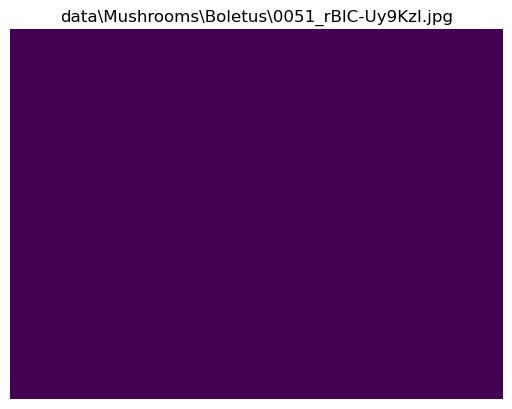

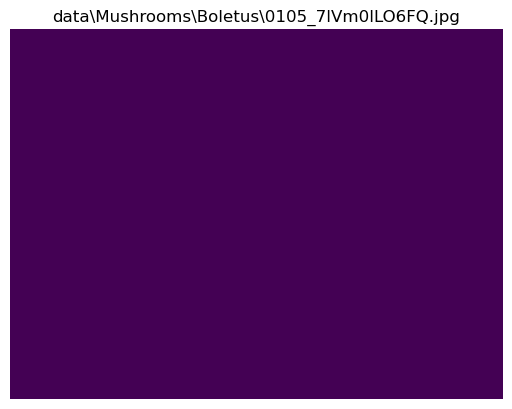


Predominantly black photos:


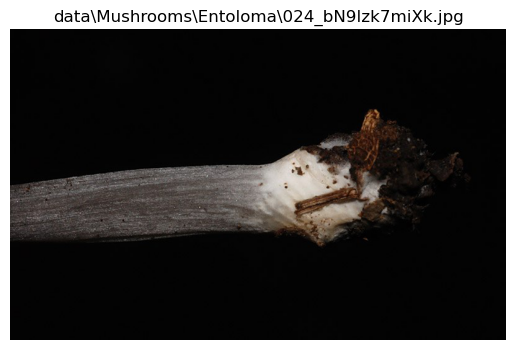

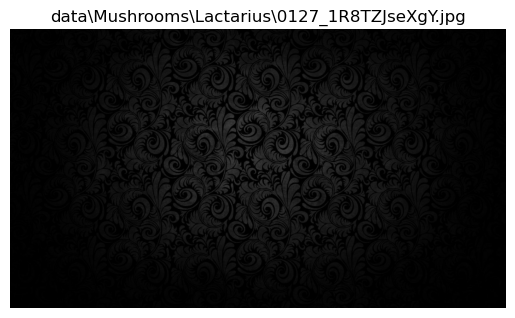

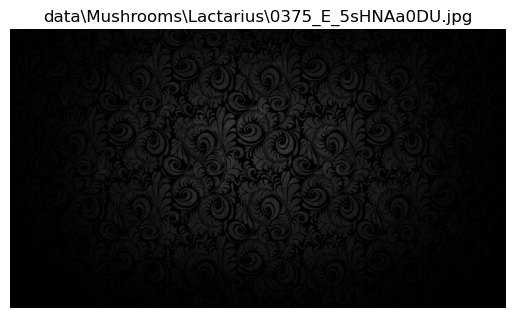

In [12]:

def show_images(image_paths):
    """
    Display images given their file paths.
    """
    for image_path in image_paths:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(image_path)
        plt.axis('off')
        plt.show()

print("Predominantly white photos:")
show_images(white_photos)

print("\nPredominantly black photos:")
show_images(black_photos)


### Removing Anomalies

In [13]:
def delete_images(image_paths):
    for image_path in image_paths:
        try:
            with open(image_path, "rb") as f:
                pass  
            os.remove(image_path)
            print(f"Deleted image: {image_path}")
        except Exception as e:
            print(f"Error deleting image {image_path}: {e}")
            
print("Deleting predominantly white photos...")
delete_images(white_photos)

print("\nDeleting predominantly black photos...")
delete_images(black_photos)

print("\nDeleting truncated photos...")
delete_images(truncated_photos)

Deleting predominantly white photos...
Deleted image: data\Mushrooms\Boletus\0051_rBIC-Uy9KzI.jpg
Deleted image: data\Mushrooms\Boletus\0105_7lVm0lLO6FQ.jpg

Deleting predominantly black photos...
Deleted image: data\Mushrooms\Entoloma\024_bN9lzk7miXk.jpg
Deleted image: data\Mushrooms\Lactarius\0127_1R8TZJseXgY.jpg
Deleted image: data\Mushrooms\Lactarius\0375_E_5sHNAa0DU.jpg

Deleting truncated photos...
Deleted image: data\Mushrooms\Russula\092_43B354vYxm8.jpg


### Data Normalization Parameters

To tailor our normalization process specifically to our dataset, we compute the mean and standard deviation of the pixel values across all images. These calculations are performed on the mushroom image dataset. By determining these statistics, we can adjust the input data such that it has a standard distribution, making it easier for the model to learn from the data.

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageDataset(root_dir='data/Mushrooms', transform=transform)

dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=10)

def compute_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for i, data in enumerate(loader, 1):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

mean, std = compute_mean_std(dataloader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.3913, 0.3695, 0.2812])
Std: tensor([0.2497, 0.2267, 0.2234])


## Conclusions

Image Format Consistency: All images are in JPG format, ensuring uniformity in data format.

Inconsistent Image Sizes: Image sizes vary across the dataset, requiring reshaping for consistency in model input.

Corrupted or Misfit Images Removed: Identified and removed corrupted or improperly formatted images that didn't meet project data requirements.

Class Imbalance Detected: Imbalance observed in data classes, indicating a need for augmentation techniques to address potential bias and enhance model performance.

Data Normalization Parameters: Calculated data normalization parameters ( Mean: tensor([0.3913, 0.3695, 0.2812]) Std: tensor([0.2497, 0.2267, 0.2234]))